# <span style="color:purple">ArcGIS API for Python</span>


## Demo: Administrative Management of Users, Roles & Groups

### We will go over a few workflows to show how the ArcGIS API can help administrators of Web GIS.

Let's import a few modules. We are importing getpass to provide the GIS object with a password in a safe manner.

In [1]:
from arcgis.gis import *
from getpass import getpass
from IPython.display import display

Let's call our GIS object and pass a local Portal.

In [2]:
password = getpass()
gis = GIS("https://esridenver.maps.arcgis.com", "pgamberg@EsriDenver", password, verify_cert=False)

········


In [3]:
gis

GIS @ https://esridenver.maps.arcgis.com version:7.1

### Querying for users

Let's run a full query for listed users:

In [4]:
gis.users.search()


[<User username:AA_student_esridenver>,
 <User username:ahenry@esridenver>,
 <User username:aknapp@esridenver>,
 <User username:alex_ocean0>,
 <User username:Alicia_Scottsdale>,
 <User username:Autumn_Maricopa>,
 <User username:A_student_esridenver>,
 <User username:bbrum_esridenver>,
 <User username:BB_student_esridenver>,
 <User username:benjaminz_gnss>,
 <User username:blegeer_esridenver>,
 <User username:B_student_esridenver>,
 <User username:carson_coates6>,
 <User username:CC_student_esridenver>,
 <User username:C_student_esridenver>,
 <User username:Das_Insights>,
 <User username:DCarroll_esridenver>,
 <User username:DD_student_esridenver>,
 <User username:dmulhern_esridenver>,
 <User username:dvaillancourt_esridenver>,
 <User username:dvaillancourt_esridenver1>,
 <User username:D_student_esridenver>,
 <User username:EE_student_esridenver>,
 <User username:Eneboe_Insights>,
 <User username:E_student_esridenver>,
 <User username:Fagan_Insights>,
 <User username:FF_student_esriden

<User username:pgamberg@EsriDenver>
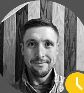

In [5]:
gis.users.me

Filter your user search...

In [6]:
gis.users.search("pete")

[<User username:Pete_viewer>, <User username:pgamberg@EsriDenver>]

Let's search for my colleague, Matt

In [7]:
gis.users.search("Matt")

User does not exist or is inaccessible.


RuntimeError: User does not exist or is inaccessible.
(Error Code: 400)

### Create a new user

Users can be created through the API

In [8]:
gis.users.create?

In [10]:
clark = gis.users.create(username = "SmithCollinss", 
                           password="COLL@123", 
                          firstname="smith", 
                          lastname="colins", 
                          email="smith.collins@company.com",  
                          role='org_user')
clark

<User username:SmithCollinss>

This variable is now a "user" object

In [11]:
type(clark)

arcgis.gis.User

Use intellisense to see all the options you have available with user objects.

In [27]:
clark.description

In [12]:
clark.email

'smith.collins@company.com'

In [13]:
clark.delete()

True

### Querying for groups

In [14]:
gis.groups.search()

[<Group title:"416 Fire Group for Workspace" owner:ShelbyHines_esridenver>,
 <Group title:"ABQ Reduce Homelessness Initiative Collaboration Group" owner:ShelbyHines_esridenver>,
 <Group title:"ABQ Reduce Homelessness Initiative Open Data Group" owner:ShelbyHines_esridenver>,
 <Group title:"Address Field Verification" owner:ShelbyHines_esridenver>,
 <Group title:"Admin Tools for Arcgis Online" owner:joseph_peters@esridenver>,
 <Group title:"AGIC Open Data" owner:jlindemann@EsriDenver>,
 <Group title:"Albuquerque Homelessness Solutions" owner:ShelbyHines_esridenver>,
 <Group title:"Boundaries" owner:joseph_peters@esridenver>,
 <Group title:"Citizen Problem Manager" owner:joseph_peters@esridenver>,
 <Group title:"Citizen Problem Manager" owner:ShelbyHines_esridenver>,
 <Group title:"Citizen Problem Manager" owner:jlindemann@EsriDenver>,
 <Group title:"Citizen Problem Reporter" owner:hmiller_esridenver>,
 <Group title:"Citizen Problem Reporter" owner:jlindemann@EsriDenver>,
 <Group title:"

Let's create the group

In [15]:
# create groups
demo_group = gis.groups.create("Field Work", "Demo; CO")

This is a "group" object

In [36]:
demo_group?

In [16]:
demo_group

<Group title:"Field Work" owner:pgamberg@EsriDenver>

In [38]:
type(demo_group)

arcgis.gis.Group

Like the user object, it has methods we can call on it

In [39]:
demo_group.access

'public'

# Let's say your boss suddenly gets an idea!


## Boss:
## "I want you to create a new portal, with new users from our regional teams and mulitple groups and make every member is part of their groups. 
## "And I need this before you go home."


## Have no fear! The ArcGIS API for Python is here to help.

We're going to import some libraries to help us

In [17]:
import csv 
import json

# Create Groups

In [18]:
def create_groups():
    print("CREATING GROUPS")

    with open("groups.csv", 'r') as groups_csv:
        groups = csv.DictReader(groups_csv)
        for group in groups:
            try:
                print(" Creating group: ", group['title'], end="  ##  ")
                result = gis.groups.create_from_dict(group)
                if result:
                    print("success")
            except Exception as create_ex:
                print("Error... ", str(create_ex))

# Add Users

In [19]:
def create_users():
    # loop through and create users
    with open("users.csv", 'r') as users_csv:
        users = csv.DictReader(users_csv)
        for user in users:
            try:
                print("Creating user: ", user['username'], end=" ## ")
                
                result = gis.users.create(username=user['username'],
                                          password=user['password'],
                                          firstname=user['Firstname'],
                                          lastname=user['Lastname'],
                                          email=user['email'],
                                          role=user['role'],
                                         )
                
                if result:
                    print("success  ##")

                    print("\t Adding to groups: ", end=" # ")
                    groups = user['groups']
                    group_list = groups.split(",")

                    # Search for the group
                    for g in group_list:
                        group_search = gis.groups.search(g)
                        if len(group_search) > 0:
                            try:
                                group = group_search[0]
                                groups_result = group.add_users([user['username']])
                                if len(groups_result['notAdded']) == 0:
                                    print(g, end =" # ")

                            except Exception as groups_ex:
                                print("\n \t Cannot add user to group ", g, str(groups_ex))
                    print("\n")

            except Exception as add_ex:
                print("Cannot create user: " + user['username'])
                print(str(add_ex))

# Publish Content

In [22]:
def publish_content():
    # Read the csv containing user accounts and their territory info
    csv_path = "users.csv"

    
    # Read template web map
    template_webmap_dict = dict()
    with open(".//user_content//web_map.json", 'r') as webmap_file:
                template_webmap_dict = json.load(webmap_file)

    # Loop through each user and publish the content
    with open(csv_path, 'r') as csv_handle:
        reader = csv.DictReader(csv_handle)
        for row in reader:
            try:
                data_to_publish = './/user_content//' + row['assigned_state'] + ".csv"

                print("Publishing ", data_to_publish, end = " # ")
                added_item = gis.content.add({}, data = data_to_publish)
                published_layer = added_item.publish()

                if published_layer is not None:
                    # publish web map
                    print('webmaps', end= " ## ")
                    user_webmap_dict = template_webmap_dict
                    user_webmap_dict['operationalLayers'][0].update({'itemId': published_layer.itemid,
                                                                     'layerType': "ArcGISFeatureLayer",
                                                                     'title': published_layer.title,
                                                                     'url': published_layer.url + r"/0"})

                    web_map_properties = {'title': '{0} {1} response locations'.format(row['Firstname'], row['Lastname']),
                                          'type': 'Web Map',
                                          'snippet': 'Areas affected by Hurricane Matthew under the supervision of' +\
                                                     '{0} {1}'.format(row['Firstname'], row['Lastname']),
                                          'tags': 'ArcGIS Python API',
                                          'typeKeywords' : "Collector, Explorer Web Map, Web Map, Map, Online Map",
                                          'text': json.dumps(user_webmap_dict)}

                    web_map_item = gis.content.add(web_map_properties)

                    print("success. Assigning to: ", end="  #  ")
                    result1 = published_layer.reassign_to(row['username'])
                    result2 = web_map_item.reassign_to(row['username'])
                    if (result1 and result2) is not None:
                        print(row['username'])
                    else:
                        print("error")
                else:
                    print(" error publishing csv")

            except Exception as pub_ex:
                print("Error : ", str(pub_ex))

# Customize the UX

In [20]:
def set_theme():
    
    folder = r'helper_files'
    print(folder)
    gis.admin.ux.set_logo(folder + r'\logo\dc_logo.png')
    gis.admin.ux.set_background(is_built_in=False)
    gis.admin.ux.set_banner(folder + r'\baked_banner\washingtondc_banner.png')
    gis.admin.ux.name = "Washington DC"
    gis.admin.ux.description = "Washington DC"

In [23]:
#set_theme()
create_groups()
create_users()
publish_content()

CREATING GROUPS
 Creating group:  Basemaps  ##  

Unable to create group.
You already have a group named 'Basemaps'. Try a different name.


Error...  Unable to create group.
You already have a group named 'Basemaps'. Try a different name.
(Error Code: 400)
 Creating group:  Central Services  ##  

Unable to create group.
You already have a group named 'Central Services'. Try a different name.
Unable to create group.


Error...  Unable to create group.
You already have a group named 'Central Services'. Try a different name.
(Error Code: 400)
 Creating group:  Compliance  ##  

You already have a group named 'Compliance'. Try a different name.


Error...  Unable to create group.
You already have a group named 'Compliance'. Try a different name.
(Error Code: 400)
 Creating group:  Customer Service, Finance, Billing and Accounting  ##  

Unable to create group.
You already have a group named 'Customer Service, Finance, Billing and Accounting'. Try a different name.


Error...  Unable to create group.
You already have a group named 'Customer Service, Finance, Billing and Accounting'. Try a different name.
(Error Code: 400)
 Creating group:  Demographic Content  ##  

Unable to create group.
You already have a group named 'Demographic Content'. Try a different name.


Error...  Unable to create group.
You already have a group named 'Demographic Content'. Try a different name.
(Error Code: 400)
Creating user:  SmithCollins ## 

Unable to create SmithCollins


Unable to create SmithCollins
Creating user:  JohnsonStewart ## 

Unable to create JohnsonStewart


Unable to create JohnsonStewart
Creating user:  WilliamsSanchez ## 

Unable to create WilliamsSanchez


Unable to create WilliamsSanchez
Creating user:  JonesMorris ## 

Unable to create JonesMorris


Unable to create JonesMorris
Creating user:  BrownRogers ## 

Unable to create BrownRogers


Unable to create BrownRogers
Creating user:  DavisReed ## 

Unable to create DavisReed


Unable to create DavisReed
Creating user:  MillerCook ## 

Unable to create MillerCook


Unable to create MillerCook
Creating user:  WilsonMorgan ## 

Unable to create WilsonMorgan


Unable to create WilsonMorgan
Creating user:  MooreBell ## 

Unable to create MooreBell


Unable to create MooreBell
Creating user:  TaylorMurphy ## 

Unable to create TaylorMurphy


Unable to create TaylorMurphy
Publishing  .//user_content//KS.csv # Error :  'error'
Publishing  .//user_content//NV.csv # Error :  'error'
Publishing  .//user_content//IN.csv # Error :  'error'
Publishing  .//user_content//NC.csv # Error :  'error'
Publishing  .//user_content//AR.csv # Error :  'error'
Publishing  .//user_content//FL.csv # Error :  'error'
Publishing  .//user_content//NH.csv # Error :  'error'
Publishing  .//user_content//ID.csv # Error :  'error'
Publishing  .//user_content//AZ.csv # webmaps ## 

You do not have permissions to access this resource or perform this operation.


success. Assigning to:   #  Error :  You do not have permissions to access this resource or perform this operation.
(Error Code: 403)
Publishing  .//user_content//LA.csv # Error :  'error'


## "We just found out that we have to remove every user from our Portal as we have to use it for another urgent project.


## Good thing we have the ArcGIS API for Python to help.

We're going to run a clean up script(clean.py) in my local IDE(PyCharm) removing everything except the admin account and some groups. 



In [24]:
def clean():
    # loop through and create users
    with open("users.csv", 'r') as users_csv:
        users = csv.DictReader(users_csv)
        for user in users:
            try:
                n = gis.users.get(user['username'])
                i = (n.items())
                for c in i:
                    c.delete()
                n.delete()
                
                

            except Exception as add_ex:
                print("exception " + user['username'])
                print(str(add_ex))
clean()

exception MooreBell
'NoneType' object has no attribute 'items'
